In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22b114b1940>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22b114c4390>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
# Get Last Date and YEar ago date

rows = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_dt = rows.date
last_dt

last_date = dt.datetime.strptime(last_dt, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database

yr_ago = last_date - dt.timedelta(days=365)
yr_ago


datetime.datetime(2016, 8, 23, 0, 0)

# Exploratory Climate Analysis

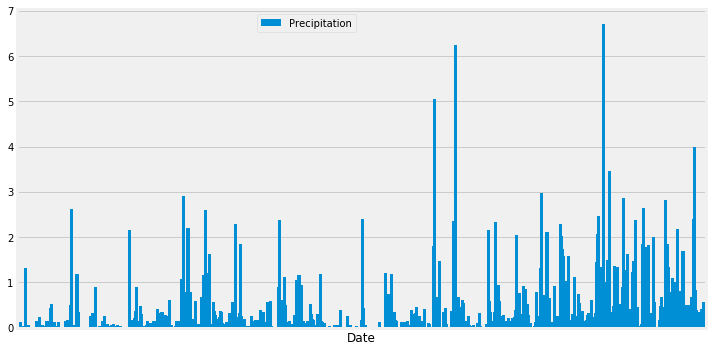

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, 
       Measurement.prcp]

prcp = session.query(*sel).\
        filter(Measurement.date >= yr_ago).\
        all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_plot_df = pd.DataFrame(prcp, columns=['Date', 'Precipitation'])


#prcp_plot_df = pd.DataFrame(prcp_df).dropna()

# Sort the dataframe by date

prcp_plot_df['Date'] = pd.to_datetime(prcp_plot_df['Date'])

prcp_plot_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot_df.plot(kind='bar', figsize=(10,5),width=10)
plt.legend(bbox_to_anchor=(0.5, 1.00))
plt.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_plot_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station=session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by (func.count(Measurement.station).desc()).\
                                all()

station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
most_act_station = station[0].station
most_act_station

'USC00519281'

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_summ = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                                  filter(Measurement.station == most_act_station).\
                                  group_by(Measurement.station).\
                                  all()
station_summ

[(54.0, 85.0, 71.66378066378067)]

In [19]:
yr_ago

datetime.datetime(2016, 8, 23, 0, 0)

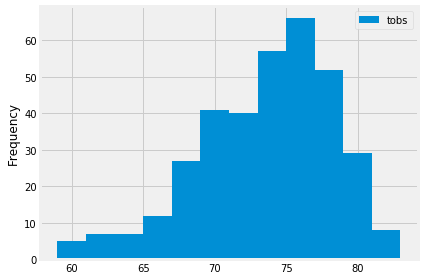

In [20]:
# Choose the station with the highest number of temperature observations.

#most active station already determined above in most_act_station

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

st_max_tobs= session.query( Measurement.date, Measurement.tobs).\
                                  filter(Measurement.station == most_act_station).\
                                  filter(Measurement.date >= yr_ago).\
                                  all()
st_max_tobs_df = pd.DataFrame(st_max_tobs, columns=(["date","tobs"]))
st_max_tobs_df.plot.hist(by=None, bins=12)  
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip_st_dt =  dt.datetime.strptime('2017-04-21', "%Y-%m-%d")

my_trip_end_dt = dt.datetime.strptime('2017-04-28', "%Y-%m-%d")

# Call CAlc_temps with previous year dates

my_trip_prev_yr_st_dt = my_trip_st_dt- dt.timedelta(days=365)

my_trip_prev_yr_end_dt = my_trip_end_dt- dt.timedelta(days=365)


my_trip_temp = calc_temps(my_trip_prev_yr_st_dt,my_trip_prev_yr_end_dt)

print (my_trip_temp)

[(68.0, 75.3913043478261, 79.0)]


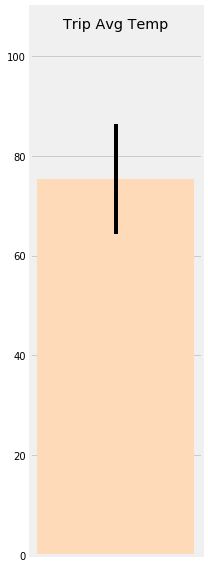

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_min_temp = my_trip_temp[0][0]
my_trip_avg_temp = my_trip_temp[0][1]
my_trip_max_temp = my_trip_temp[0][2]

my_yerr = my_trip_max_temp - my_trip_min_temp
plt.figure(figsize=(3,8))
plt.bar(my_trip_max_temp, my_trip_avg_temp,  yerr=my_yerr, color='peachpuff', width = .05)
plt.ylabel='Temp (F)'
plt.ylim(0,110)
plt.title("Trip Avg Temp",y = 0.95)
plt.xticks([])
plt.tight_layout()
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#MY TRIP IS DEFINED ANDREUSED FOR THIS ANALYSIS

#st_max_tobs_df = pd.DataFrame(st_max_tobs, columns=(["date","tobs"]))

tot_rain = session.query( Measurement.station,Station.name, Station.latitude, Station.longitude,Station.elevation).\
                                filter(Measurement.station == Station.station).\
                                filter(Measurement.date >= my_trip_prev_yr_st_dt).\
                                filter(Measurement.date <= my_trip_prev_yr_end_dt).\
                                group_by(Measurement.station).\
                                order_by(func.sum(Measurement.prcp).desc()).\
                                all()

tot_rain


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [25]:
# Display in Data Frame for Readability
tot_rain_df= pd.DataFrame(tot_rain, columns=(["Station","Station Name", "Latitude","Longitude","Elevation"]))

tot_rain_df


,Station,Station Name,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
